This notebook aims to analyze the aquaplanet TC nondevelopers and developers and their interactions with convectively coupled kelvin waves (CCKWs). Developers/non-developers were found from a precompiled list from Rosimar Rios-Berrios, and CCKW data in hovmoller form was also provided by Rosi.  

In [2]:
# Import relevant packages


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os
import random


2025-04-19 12:04:52.814424: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-19 12:04:52.848165: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Load data from file Rosi sent me over email, all developing/nondeveloping candidates.

# Question for Rosi - how was this developed?
all_cases = pd.read_csv("basic_output_from_TRACK_25Jan2023_all_candidates")

# This dataset starts on March 30 00:00:00, so create & adjust day column to match the kelvin wave data which starts 12 hrs prior
all_cases["day_adj"] = (all_cases["fhr"] + 12) / 24

In [4]:
# Total number of cases over simulation (both developers and nondevelopers)

all_IDs_cnt = all_cases["ID"].nunique()
print(all_IDs_cnt)

1212


In [5]:
# Load in tropical cyclogenesis data (at all latitudes)
tcg_cases = pd.read_csv("TCG_TC_3km_35N1tstepwarmcore_unstructuredmesh.csv")
tcg_cases

,ID,fhr,valid_time,lat_TRACK,lon_TRACK,rmw,sym_rmw,lat,lon,rmw_pcentroid_pmin_r100,sym_rmw_pcentroid_pmin_r100,lat_pmin,lon_pmin,rmw_pmin,sym_rmw_pmin,vmax,pmin,test
0,3,78.0,2000-04-02_06.00.00,10.190759,7.860233,184.265366,212.5,9.486454,7.264047,199.789107,232.5,9.523093,6.648126,NaN,202.5,20.420763,1007.225645,2
1,8,138.0,2000-04-04_18.00.00,35.234333,34.126236,105.178185,142.5,35.023136,33.555920,83.744110,222.5,35.023136,33.555920,83.744110,222.5,27.544331,989.468691,2
2,14,54.0,2000-04-01_06.00.00,6.050262,114.601227,35.262150,137.5,6.220308,115.045265,29.181723,12.5,6.220308,115.045265,29.181723,12.5,17.995691,1006.848555,4
3,20,66.0,2000-04-01_18.00.00,12.111339,158.373260,112.149239,147.5,11.723816,158.784059,50.180496,112.5,11.473916,158.960600,20.207764,102.5,13.190395,1007.095918,3
4,26,102.0,2000-04-03_06.00.00,48.514194,261.458832,197.499069,287.5,50.103108,263.784710,194.034905,77.5,49.869274,263.213170,168.708801,217.5,13.469060,982.151797,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,6556,3174.0,2000-08-09_06.00.00,4.653633,35.725407,35.355469,37.5,6.926748,37.147794,147.315694,277.5,5.172848,36.904790,170.338623,22.5,14.494739,1011.469414,1
196,6579,3162.0,2000-08-08_18.00.00,27.873886,69.886299,183.100037,297.5,27.229933,70.268425,182.141907,297.5,27.229933,70.268425,NaN,297.5,9.182191,NaN,0
197,6654,3048.0,2000-08-04_00.00.00,10.030852,333.958893,174.854370,292.5,11.775613,333.988993,195.957464,297.5,11.523514,333.866150,NaN,292.5,13.533159,1013.020215,2
198,6684,3096.0,2000-08-06_00.00.00,35.666142,153.724945,130.022430,292.5,35.678333,152.405300,15.420455,297.5,35.678333,152.405300,15.420455,297.5,21.303389,NaN,0


In [6]:
# Get # of storms associated with tropical cyclogenesis (at all latitudes)
tcg_IDs_cnt = tcg_cases["ID"].nunique()
tcg_IDs_cnt

200

In [7]:
# Remove the developers from the total list
tcg_IDs = tcg_cases["ID"].unique()
all_IDs = all_cases["ID"].unique()

# Find the unique values not common to both lists using set symmetric difference
unique_values = list(set(tcg_IDs) ^ set(all_IDs))

# Timeseries of all nondevelopers
all_ndv = all_cases[all_cases["ID"].isin(unique_values)]
all_ndv_cnt = all_ndv.nunique()


# Timeseries of nondevelopers that are close to the equator below 20N (should we adjust this? Rosi truncates the list of developers to be ones that developed at <20N, but CCKW defined 5S-10N).

lat_lim = 20
eq_ndv_raw = all_ndv[all_ndv["lat_TRACK"] < lat_lim]

unique_eq_ndv = eq_ndv_raw.nunique()

In [8]:
unique_eq_ndv
# 576 non-developers that meet this criteria!

ID             576
fhr            536
valid_time     536
lon_TRACK     7750
lat_TRACK     7749
vor850        7732
day_adj        536
dtype: int64

In [9]:
# Ok so it's 200 total cyclones forming during the aquaplanet simulation, but we are only interested in the subset of 33
# that form 1-3ish days after interaction w/ a CCKW.

# Now the question is: how many of these nondevelopers don't form after interacting with a CCKW?
# Also need to filter by latitude

In [10]:
# Load in CCKW Hovmoller Data

data = np.load("cckw_hovmoller_data.npz")
X = data["X"]
Y = data["Y"]
waveData = data["waveData"]
waveDatadt_pos = data["waveDatadt_pos"]

Text(0, 0.5, 'Day')

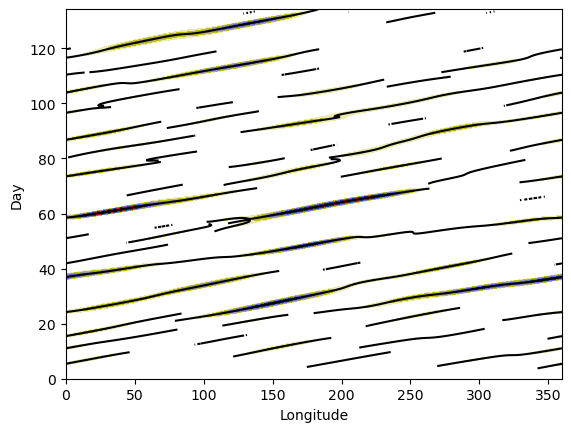

In [11]:
# Quick check of the hovmoller data

cs = plt.contour(X, Y, waveDatadt_pos, levels=[0], colors="k")
plt.contourf(X, Y, waveData, extend="both", cmap="gist_stern_r")
plt.xlabel("Longitude")
plt.ylabel("Day")



In [12]:
zero_pts = cs.allsegs


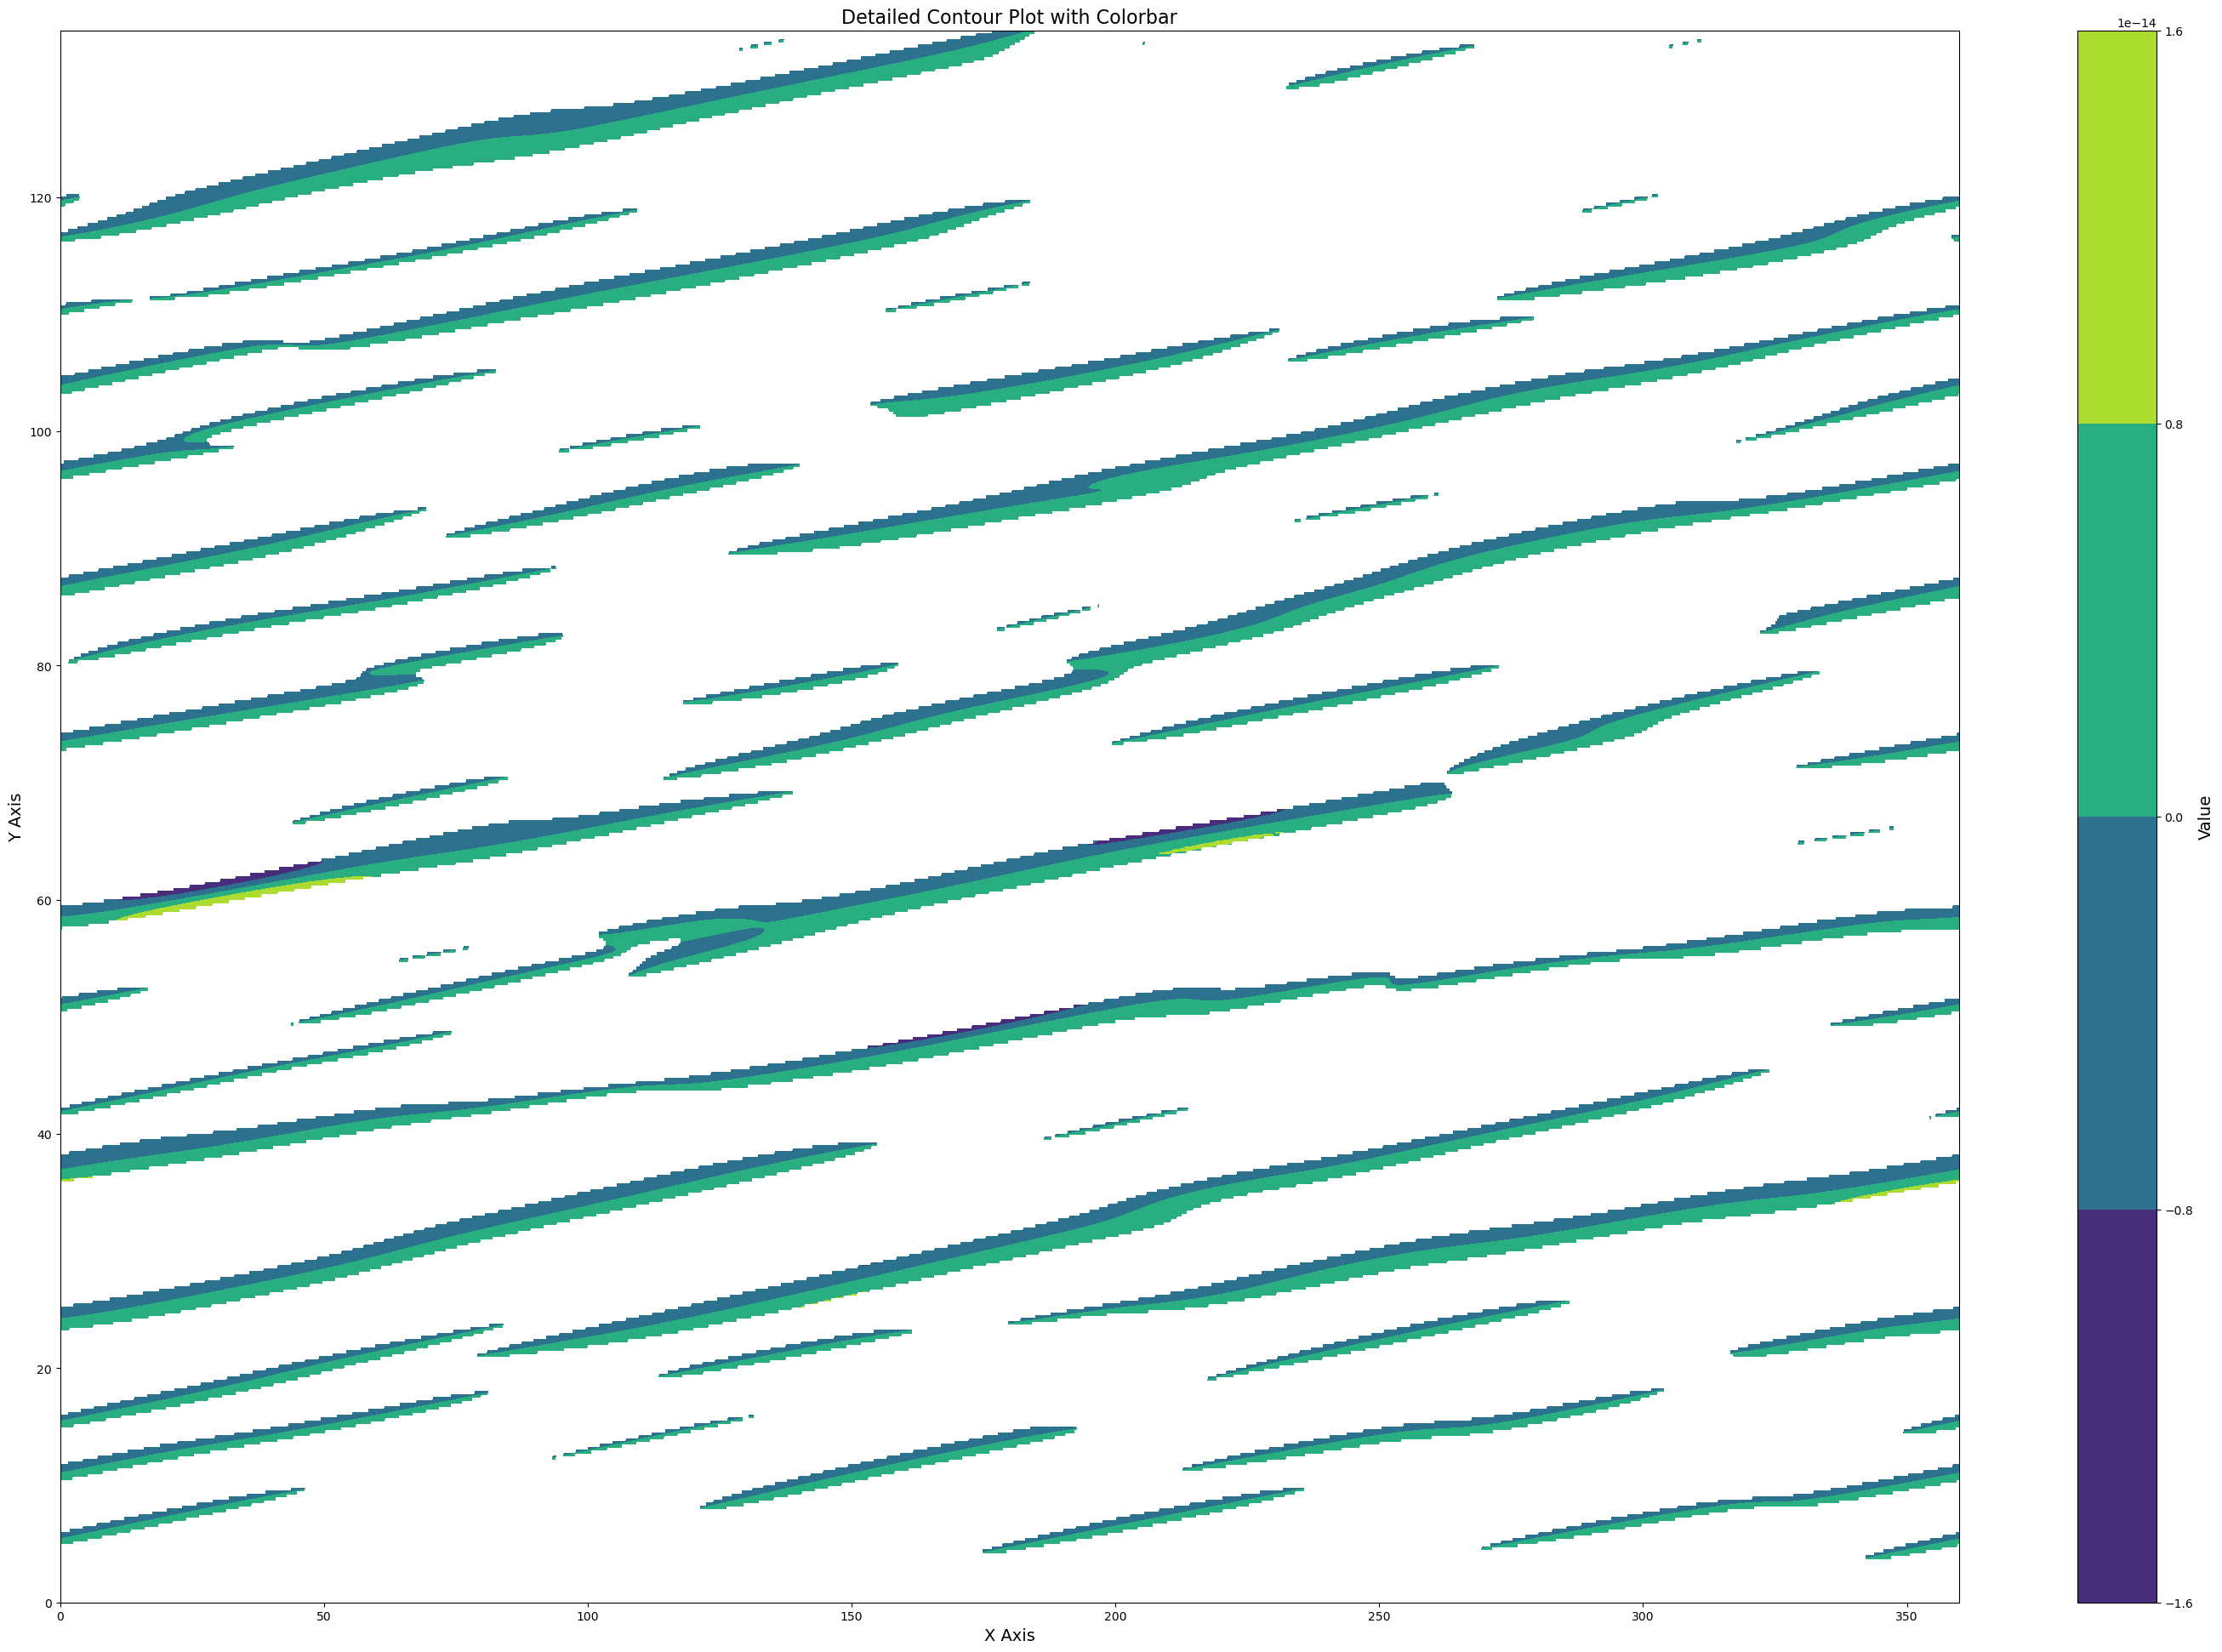

In [13]:
#Quick check of the CCKW crest contour data 
plt.figure(figsize=(36, 24))
#contourplot = plt.contour(X,Y,waveDatadt_pos)
#plt.contour(X,Y,waveDatadt_pos,levels=[0],colors='k')
#plt.colorbar(contourplot)

# Create a contour plot with more levels and a better colormap
contour = plt.contourf(X, Y, waveDatadt_pos, levels=3, cmap='viridis')  # More levels for nuance

# Add a colorbar for the legend
cbar = plt.colorbar(contour)
cbar.set_label('Value', fontsize=14)  # Label for colorbar

# Set plot titles and labels
plt.title("Detailed Contour Plot with Colorbar", fontsize=16)
plt.xlabel("X Axis", fontsize=14)
plt.ylabel("Y Axis", fontsize=14)

# Show the plot
plt.show()

In [14]:
# To be safe, create a copy of the equatorial nondeveloper dataset
eq_ndv = eq_ndv_raw.copy()

# Groupby the equatorial nondevelopers by ID.

eq_ndv_groupID = eq_ndv.groupby("ID")

eq_ndv_groupID.tail(15)

,ID,fhr,valid_time,lon_TRACK,lat_TRACK,vor850,day_adj
166,5,228.0,2000-04-08 12:00:00,1.738610,15.365438,1.067093,10.00
167,5,234.0,2000-04-08 18:00:00,1.228861,15.591279,1.013762,10.25
168,5,240.0,2000-04-09 00:00:00,0.690605,15.239415,1.154799,10.50
169,5,246.0,2000-04-09 06:00:00,358.736023,14.347824,1.518751,10.75
170,5,252.0,2000-04-09 12:00:00,356.840393,14.281115,1.383791,11.00
...,...,...,...,...,...,...,...
24924,6701,2952.0,2000-07-31 00:00:00,279.824677,14.455955,1.475276,123.50
24925,6701,2958.0,2000-07-31 06:00:00,280.385345,14.204089,1.080946,123.75
24926,6701,2964.0,2000-07-31 12:00:00,280.754852,13.989798,0.966137,124.00
24927,6701,2970.0,2000-07-31 18:00:00,280.298828,13.790131,0.974042,124.25


In [15]:
# While we're at it, let's also create a groupby object for the equatorial developers by ID.

devData_raw = pd.read_csv("Kelvin_TCG_on_peak_TempestExtremes.csv")
devData = devData_raw.copy()
devData["day_adj"] = (devData["fhr"] + 12) / 24  # Adjust the time to match CCKW


developer_IDs = devData["ID"].unique()  # Get all developer IDs for the 33 cases <20N
eq_dv = all_cases[
    all_cases["ID"].isin(developer_IDs)
]  # Extract the 33 cases from the overall dataset
eq_dv_groupID = eq_dv.groupby("ID")  # Group the 33 equatorial developers by ID

Now that we have groupby objects for our developers & nondeveloper candidates in the aquaplanet simulation, we now shift gears to analyzing their interactions with the CCKW crests(?) 
TO DO: CONFIRM THAT THEY ARE CRESTS WITH ROSI! 

In [16]:
#Need to look into Rosi's code and match what she's doing here! 


#Find the indices where the wave data time derivative data is closest to zero -> this should correspond with the crest of the CCKW activate phase

#Take waveDatadt_pos from Rosi's script 
rows, cols = waveDatadt_pos.shape
zero_locs = []

for i in range(rows - 1):
    for j in range(cols - 1):
        # Check horizontal sign change
        if waveDatadt_pos[i, j] * waveDatadt_pos[i, j + 1] < 0:
            zero_locs.append((i, j))

        # Check vertical sign change
        if waveDatadt_pos[i, j] * waveDatadt_pos[i + 1, j] < 0:
            zero_locs.append((i, j))

# Convert to numpy array for easy indexing
zero_locs_raw = np.array(zero_locs)

# Broaden indices? 
event_indices = zero_locs_raw

# List to hold expanded indices
expanded_indices = []
grid_size = (rows,cols)

# Function to expand indices
def expand_indices(event_indices, grid_size):
    for idx in event_indices:
        i, j = idx
        
        # Loop over all adjacent indices (including diagonals)
        for di in [-1, 0, 1]:  # Change in x direction
            for dj in [-1, 0, 1]:  # Change in y direction
                ni, nj = i + di, j + dj
                
                # Ensure indices are within bounds
                if 0 <= ni < grid_size[0] and 0 <= nj < grid_size[1]:
                    expanded_indices.append([ni, nj])
    
    # Remove duplicates by converting to a NumPy array and then back to a list
    return np.unique(expanded_indices, axis=0)

# Get the expanded indices
expanded_indices = expand_indices(event_indices, grid_size)

print("Expanded Indices:")
print(expanded_indices)

#4/1/25 - let's hold off on broadening the indices for now! 
#-----------------------------------------------------------
zero_locs = zero_locs_raw

Expanded Indices:
[[  14 3420]
 [  14 3421]
 [  14 3422]
 ...
 [ 537 1829]
 [ 537 1830]
 [ 537 1831]]


In [17]:

def plot_storms(eq_ndv_groupID, waveDatadt_pos, X, Y):

    # Initialize variables
    master_df = pd.DataFrame() 
    ndv_track = np.zeros(waveDatadt_pos.shape)
    ndv_track_cckw_intersection = np.zeros(waveDatadt_pos.shape)
    ndv_cckw_list = []
    updated_groups=[]
    k=0
    
    # For loop over each storm
    for ID, group in eq_ndv_groupID:
        day_adj = group["day_adj"]  # get all day information for one ndv ID
        lon_track = group["lon_TRACK"]  # get all longitude information for one ndv ID
        cross = np.zeros(len(lon_track))  # initialize the array that determines whether a CCKW is intersecting with the ndv path.
    
        for i in range(0, len(lon_track) - 1):  # For the length of the longitude track
            # Find the min and max longitude between two given steps
            lon1 = lon_track.iloc[i]
            lon2 = lon_track.iloc[i + 1]
    
            if lon1 > lon2:
                lon_min = lon2
                lon_max = lon1
            else:
                lon_min = lon1
                lon_max = lon2
    
            # Find the min and max time between two given steps
            day_min = day_adj.iloc[i]
            day_max = day_adj.iloc[i + 1]
    
            # Find all indices of the 2D array between the day and longitude steps
            indices = np.where(
                (X >= lon_min) & (X < lon_max) & (Y >= day_min) & (Y < day_max)
            )
    
            # Convert zero_locs to set of tuples
            indices_tuples = set(zip(indices[0], indices[1]))
            zero_locs_tuples = set(map(tuple, zero_locs))
    
            # Check if any (x, y) pair exists
            cross[i] = int(bool(indices_tuples & zero_locs_tuples))  # Intersection
    
            # For each step get the storm's longitude and day -> need to find the closest index match in the longitude/day mesh grids.
            target_lon = lon_track.iloc[i]
            target_day = day_adj.iloc[i]
    
            # Find the index of the closest value (these both return a tuple)
            idx_lon_raw = np.unravel_index(np.abs(X - target_lon).argmin(), X.shape)
            idx_day_raw = np.unravel_index(np.abs(Y - target_day).argmin(), X.shape)
    
            # We want the column value of longitude and the row value of day
            idx_lon = idx_lon_raw[1]
            idx_day = idx_day_raw[0]
    
            # Set closest lon, day match to 1 in array
            ndv_track[idx_day, idx_lon] = 1
    
            # If our storm path is intersecting with a CCKW crest set value to one (note that too).
            if cross[i] == 1:
                ndv_track_cckw_intersection[idx_day, idx_lon] = 1
    
        group['cckw_crest_cross']=cross 
        updated_groups.append(group)
    
        # If our storm is crossing a cckw crest note that it is and append to list
        if np.sum(cross) > 0:
            ndv_cckw_list.append(ID)
    
            k +=1
            
    eq_ndv_updated = pd.concat(updated_groups, ignore_index=True)


    return (
        ndv_track,
        ndv_track_cckw_intersection,
        eq_ndv_updated,
        ndv_cckw_list
    )



In [18]:
#Get track data for all nondevelopers, all data

ndv_track, ndv_track_cckw_intersection,eq_ndv_updated,ndv_cckw_list = plot_storms(
    eq_ndv_groupID, waveDatadt_pos, X, Y
)


In [19]:
len(ndv_cckw_list)

195

In [20]:
dv_track, dv_track_cckw_intersection, eq_dv_updated, dv_cckw_list = plot_storms(eq_dv_groupID, waveDatadt_pos, X, Y)

In [21]:
all_ndv

,ID,fhr,valid_time,lon_TRACK,lat_TRACK,vor850,day_adj
77,4,228.0,2000-04-08 12:00:00,217.093750,46.673222,1.178875,10.00
78,4,234.0,2000-04-08 18:00:00,219.678955,46.105976,1.478774,10.25
79,4,240.0,2000-04-09 00:00:00,222.205673,45.548641,1.544279,10.50
80,4,246.0,2000-04-09 06:00:00,224.650238,44.538479,1.528071,10.75
81,4,252.0,2000-04-09 12:00:00,227.360931,43.605938,1.534821,11.00
...,...,...,...,...,...,...,...
24970,6706,3102.0,2000-08-06 06:00:00,278.704163,26.471022,1.195978,129.75
24971,6706,3108.0,2000-08-06 12:00:00,280.316345,25.830238,1.155432,130.00
24972,6706,3114.0,2000-08-06 18:00:00,281.142914,24.706772,1.214352,130.25
24973,6706,3120.0,2000-08-07 00:00:00,281.602112,23.984079,1.204661,130.50


In [22]:
# Find exact locations of TC genesis
tcgen_day = np.zeros(len(devData))
tcgen_lon = np.zeros(len(devData))
tcgen_ID = np.zeros(len(devData))

tcgen_dv = np.zeros(waveDatadt_pos.shape)

for i in range(0, len(devData)):
    tcgen_day[i] = devData.loc[i, "day_adj"]
    tcgen_lon[i] = devData.loc[i, "lon_TRACK"]
    tcgen_ID[i] = devData.loc[i, "ID"]

    # Find the index of the closest value
    idx_lon_raw = np.unravel_index(np.abs(X - tcgen_lon[i]).argmin(), X.shape)
    idx_day_raw = np.unravel_index(np.abs(Y - tcgen_day[i]).argmin(), X.shape)

    idx_lon = idx_lon_raw[1]
    idx_day = idx_day_raw[0]

    tcgen_dv[idx_day, idx_lon] = 1

# idx_lon_raw
idx_day_raw

(525, 0)

In [23]:
# Find exact locations of TC genesis
tcgen_day = np.zeros(len(devData))
tcgen_lon = np.zeros(len(devData))
tcgen_ID = np.zeros(len(devData))
idx_lon_raw = np.zeros(len(devData))
idx_day_raw = np.zeros(len(devData))

for i in range(0, len(devData)):
    tcgen_day[i] = devData.loc[i, "day_adj"]
    tcgen_lon[i] = devData.loc[i, "lon_TRACK"]
    tcgen_ID[i] = devData.loc[i, "ID"]

    # Find the index of the closest value
    idx_lon_raw[i] = np.unravel_index(np.abs(X - tcgen_lon[i]).argmin(), X.shape)[1]
    idx_day_raw[i] = np.unravel_index(np.abs(Y - tcgen_day[i]).argmin(), X.shape)[0]

tcgen_idx_lon = idx_lon_raw.astype(int)
tcgen_idx_day = idx_day_raw.astype(int)

tcgen_indices = [tcgen_idx_day, tcgen_idx_lon]

In [24]:
#Find the points where ndv_track_cckw_intersection equals 1
indices_ndv = np.where(np.isclose(ndv_track_cckw_intersection, 1))
indices_dv = np.where(np.isclose(dv_track_cckw_intersection, 1))
indices_tcgen = np.where(np.isclose(tcgen_dv, 1))

indices_dv

(array([ 21,  81,  85,  88,  89,  90,  90, 100, 103, 104, 105, 105, 106,
        107, 113, 117, 126, 135, 137, 139, 149, 162, 169, 172, 187, 199,
        226, 229, 233, 234, 235, 236, 237, 238, 239, 258, 261, 263, 264,
        272, 311, 332, 348, 355, 364, 376, 381, 387, 393, 394, 396, 414,
        414, 416, 418, 419, 420, 421, 422, 422, 423, 424, 425, 425, 429,
        434, 445, 450, 451, 457, 458, 458, 459, 492, 510, 511, 531]),
 array([2787,  508, 2398, 3287,  696,  700,  994, 3593,  164,  228,  268,
         282, 1428, 2251,  477,  597,  776, 3148,    2, 3599,   44,  534,
        2966,  127,    9, 3470, 3212, 1077, 3557, 3592,   31,   67,  101,
         142,  192, 3576,  918,  975, 2276,  608, 1868,  315,   64,    9,
        1498, 3287, 1202, 2111, 2278,  990, 1051,  631, 2807, 1847, 3592,
          42,   93,  132,  164, 2019,  191,  215,  231, 3138,  513, 2636,
        1678, 1115, 1127,  608,  638, 1346,  642,  626, 3590, 1199, 1305]))

(array([  0.,  20.,  40.,  60.,  80., 100., 120., 140.]),
 [Text(0, 0.0, '0'),
  Text(0, 20.0, '20'),
  Text(0, 40.0, '40'),
  Text(0, 60.0, '60'),
  Text(0, 80.0, '80'),
  Text(0, 100.0, '100'),
  Text(0, 120.0, '120'),
  Text(0, 140.0, '140')])

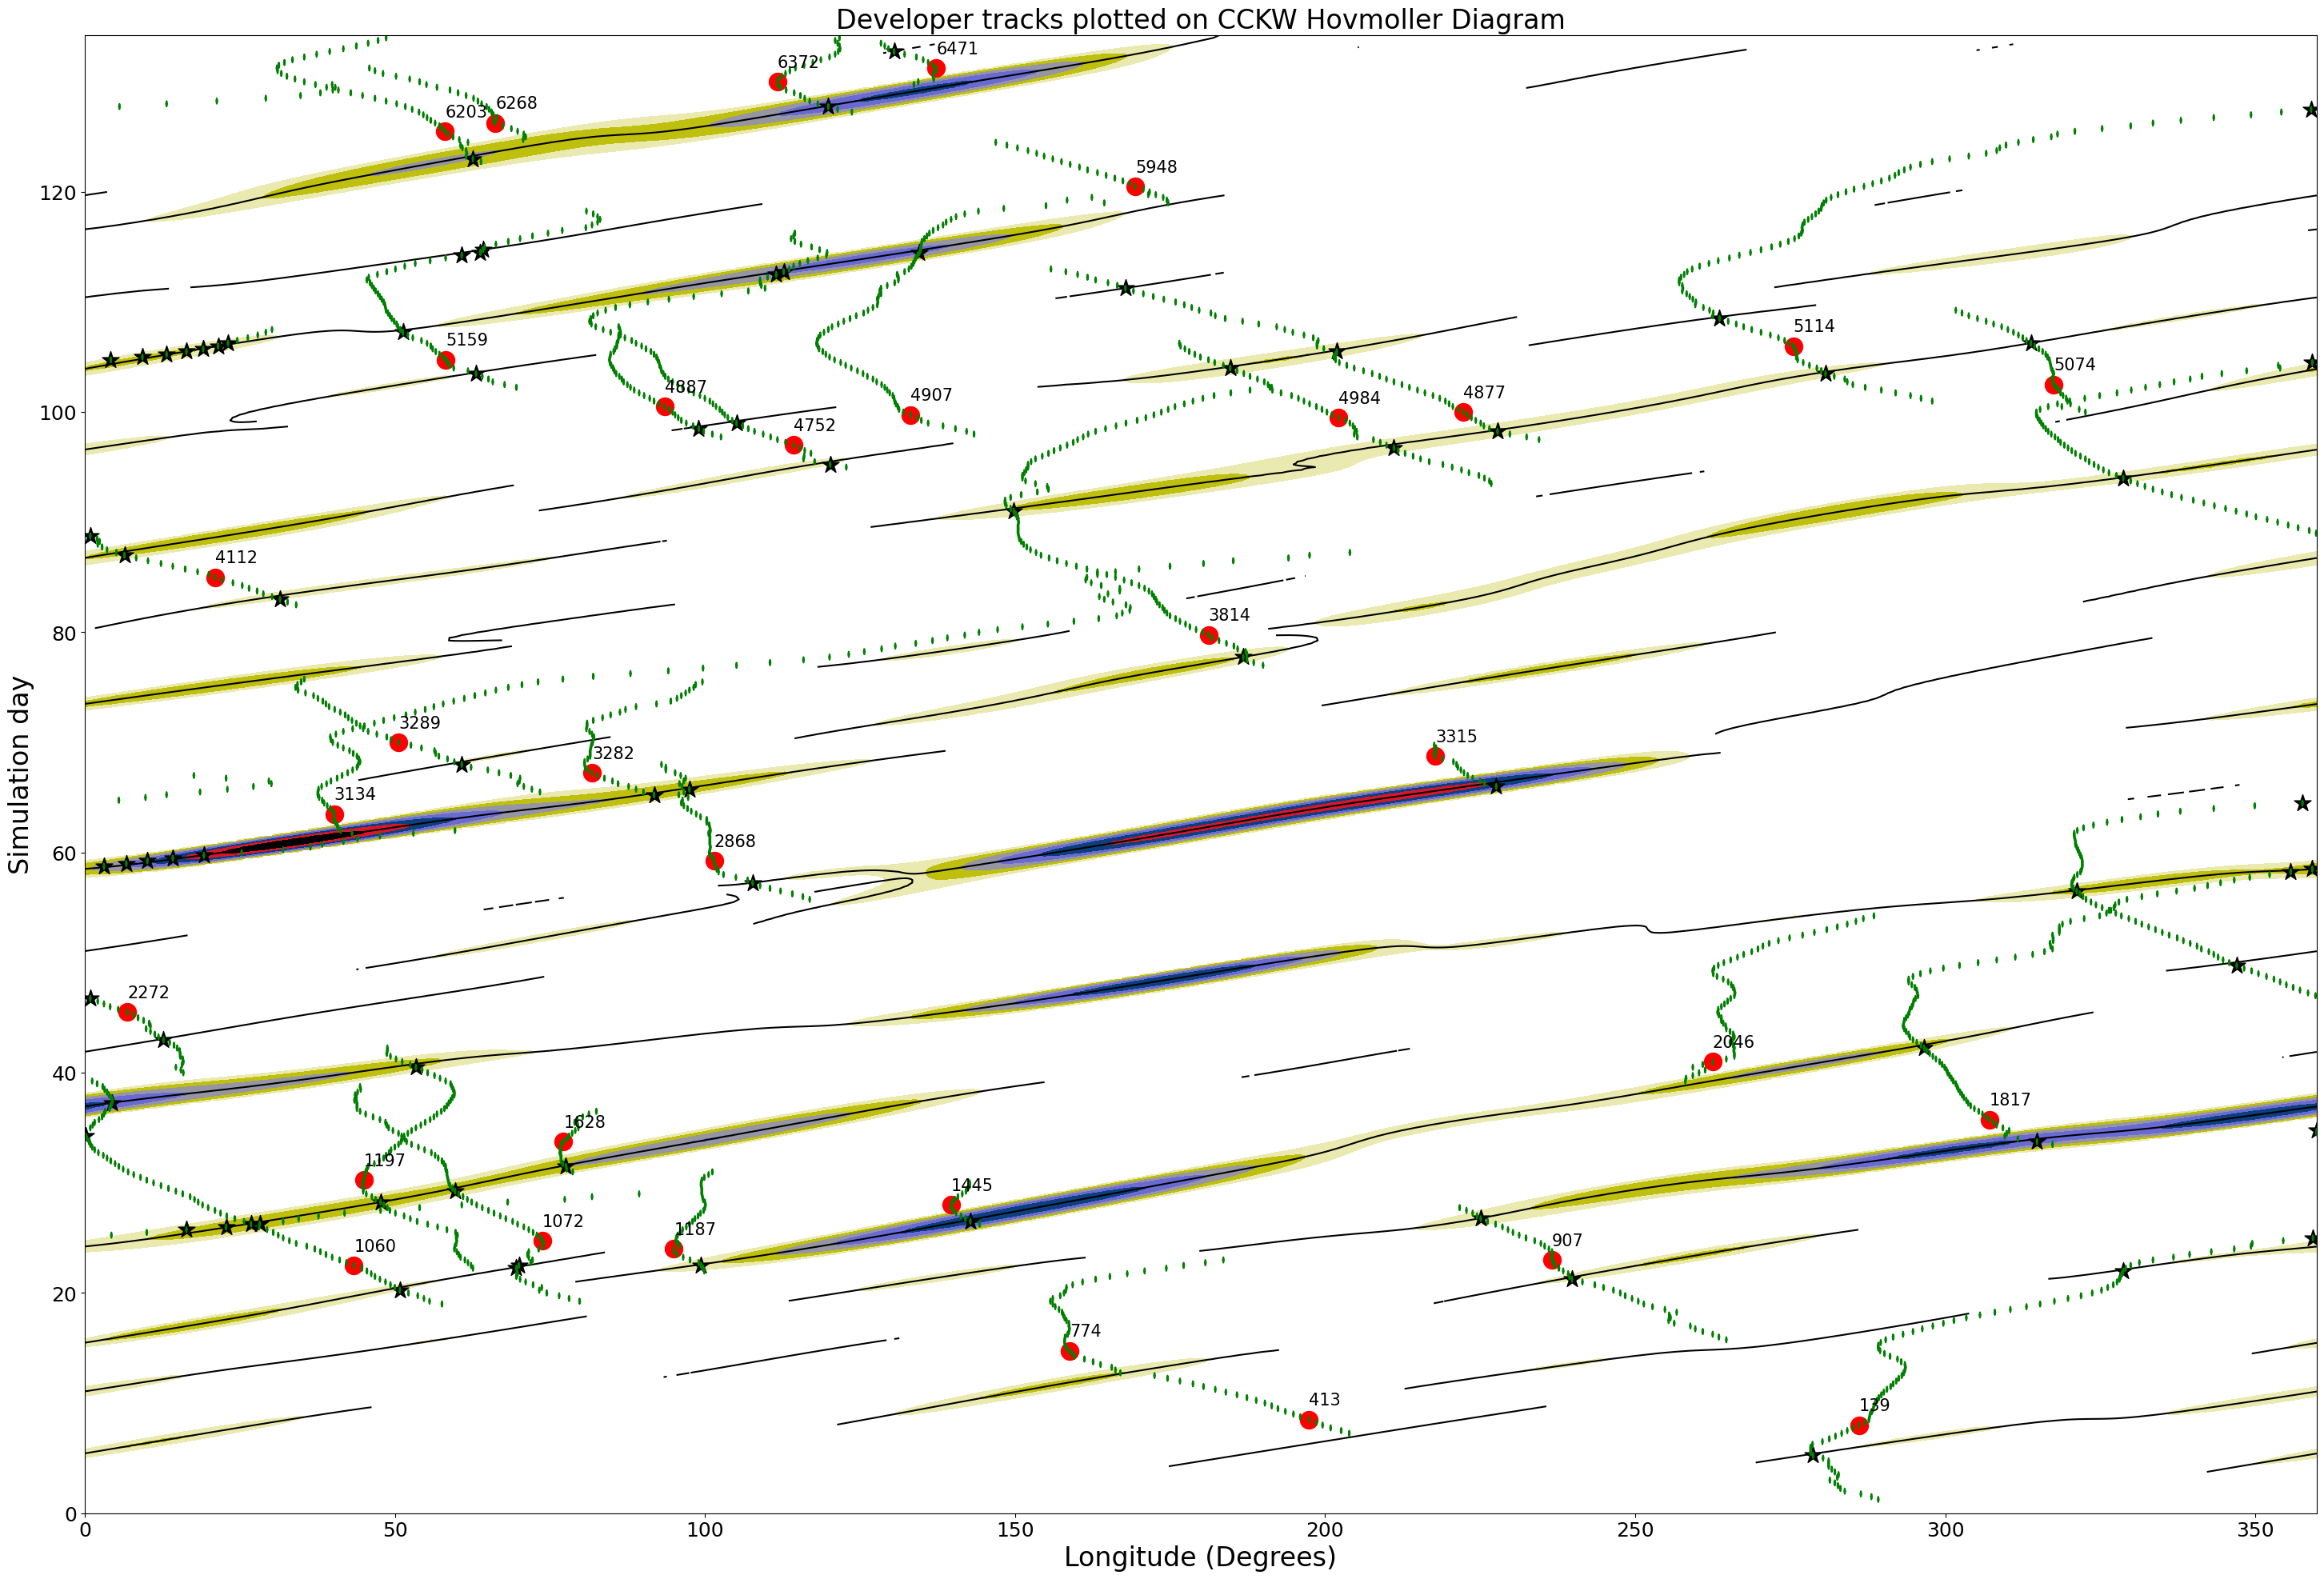

In [25]:
plt.figure(figsize=(36,24))  # Adjust the figure size as needed
cs = plt.contour(X,Y,waveDatadt_pos,levels=[0],colors='k')
plt.contourf(X,Y, waveData, extend='both',cmap='gist_stern_r')
#plt.contour(X,Y,ndv_track,levels=[0],colors='r')
plt.contour(X,Y,dv_track,levels=[0],colors='g')



#Find the points where ndv_track_cckw_intersection equals 1
#indices_ndv = np.where(np.isclose(ndv_track_cckw_intersection, 1))
indices_dv = np.where(np.isclose(dv_track_cckw_intersection, 1))
indices_tcgen = np.where(np.isclose(tcgen_dv, 1))

# Plot stars at these points
#plt.scatter(X[indices_ndv], Y[indices_ndv], color='b', marker='*', s=100, label='ndv_track_cckw_intersection = 1')
plt.scatter(X[indices_dv], Y[indices_dv], color='k', marker='*', s=250, label='dv_track_cckw_intersection = 1')
plt.scatter(X[tcgen_idx_day,tcgen_idx_lon], Y[tcgen_idx_day,tcgen_idx_lon], color='r', marker='o', s=250)

# Add text labels next to each point
for i in range(len(tcgen_idx_day)):
   plt.text(X[tcgen_idx_day[i],tcgen_idx_lon[i]],Y[tcgen_idx_day[i]+7,tcgen_idx_lon[i]],tcgen_ID[i].astype(int).astype(str),fontsize=15, verticalalignment='center')

plt.xlabel('Longitude (Degrees)',fontsize=24) 
plt.ylabel('Simulation day',fontsize=24) 
plt.title('Developer tracks plotted on CCKW Hovmoller Diagram',fontsize=24) 
plt.xticks(fontsize=18)  # Increase font size of x-ticks
plt.yticks(fontsize=18)  # Increase font size of y-ticks


(array([  0.,  20.,  40.,  60.,  80., 100., 120., 140.]),
 [Text(0, 0.0, '0'),
  Text(0, 20.0, '20'),
  Text(0, 40.0, '40'),
  Text(0, 60.0, '60'),
  Text(0, 80.0, '80'),
  Text(0, 100.0, '100'),
  Text(0, 120.0, '120'),
  Text(0, 140.0, '140')])

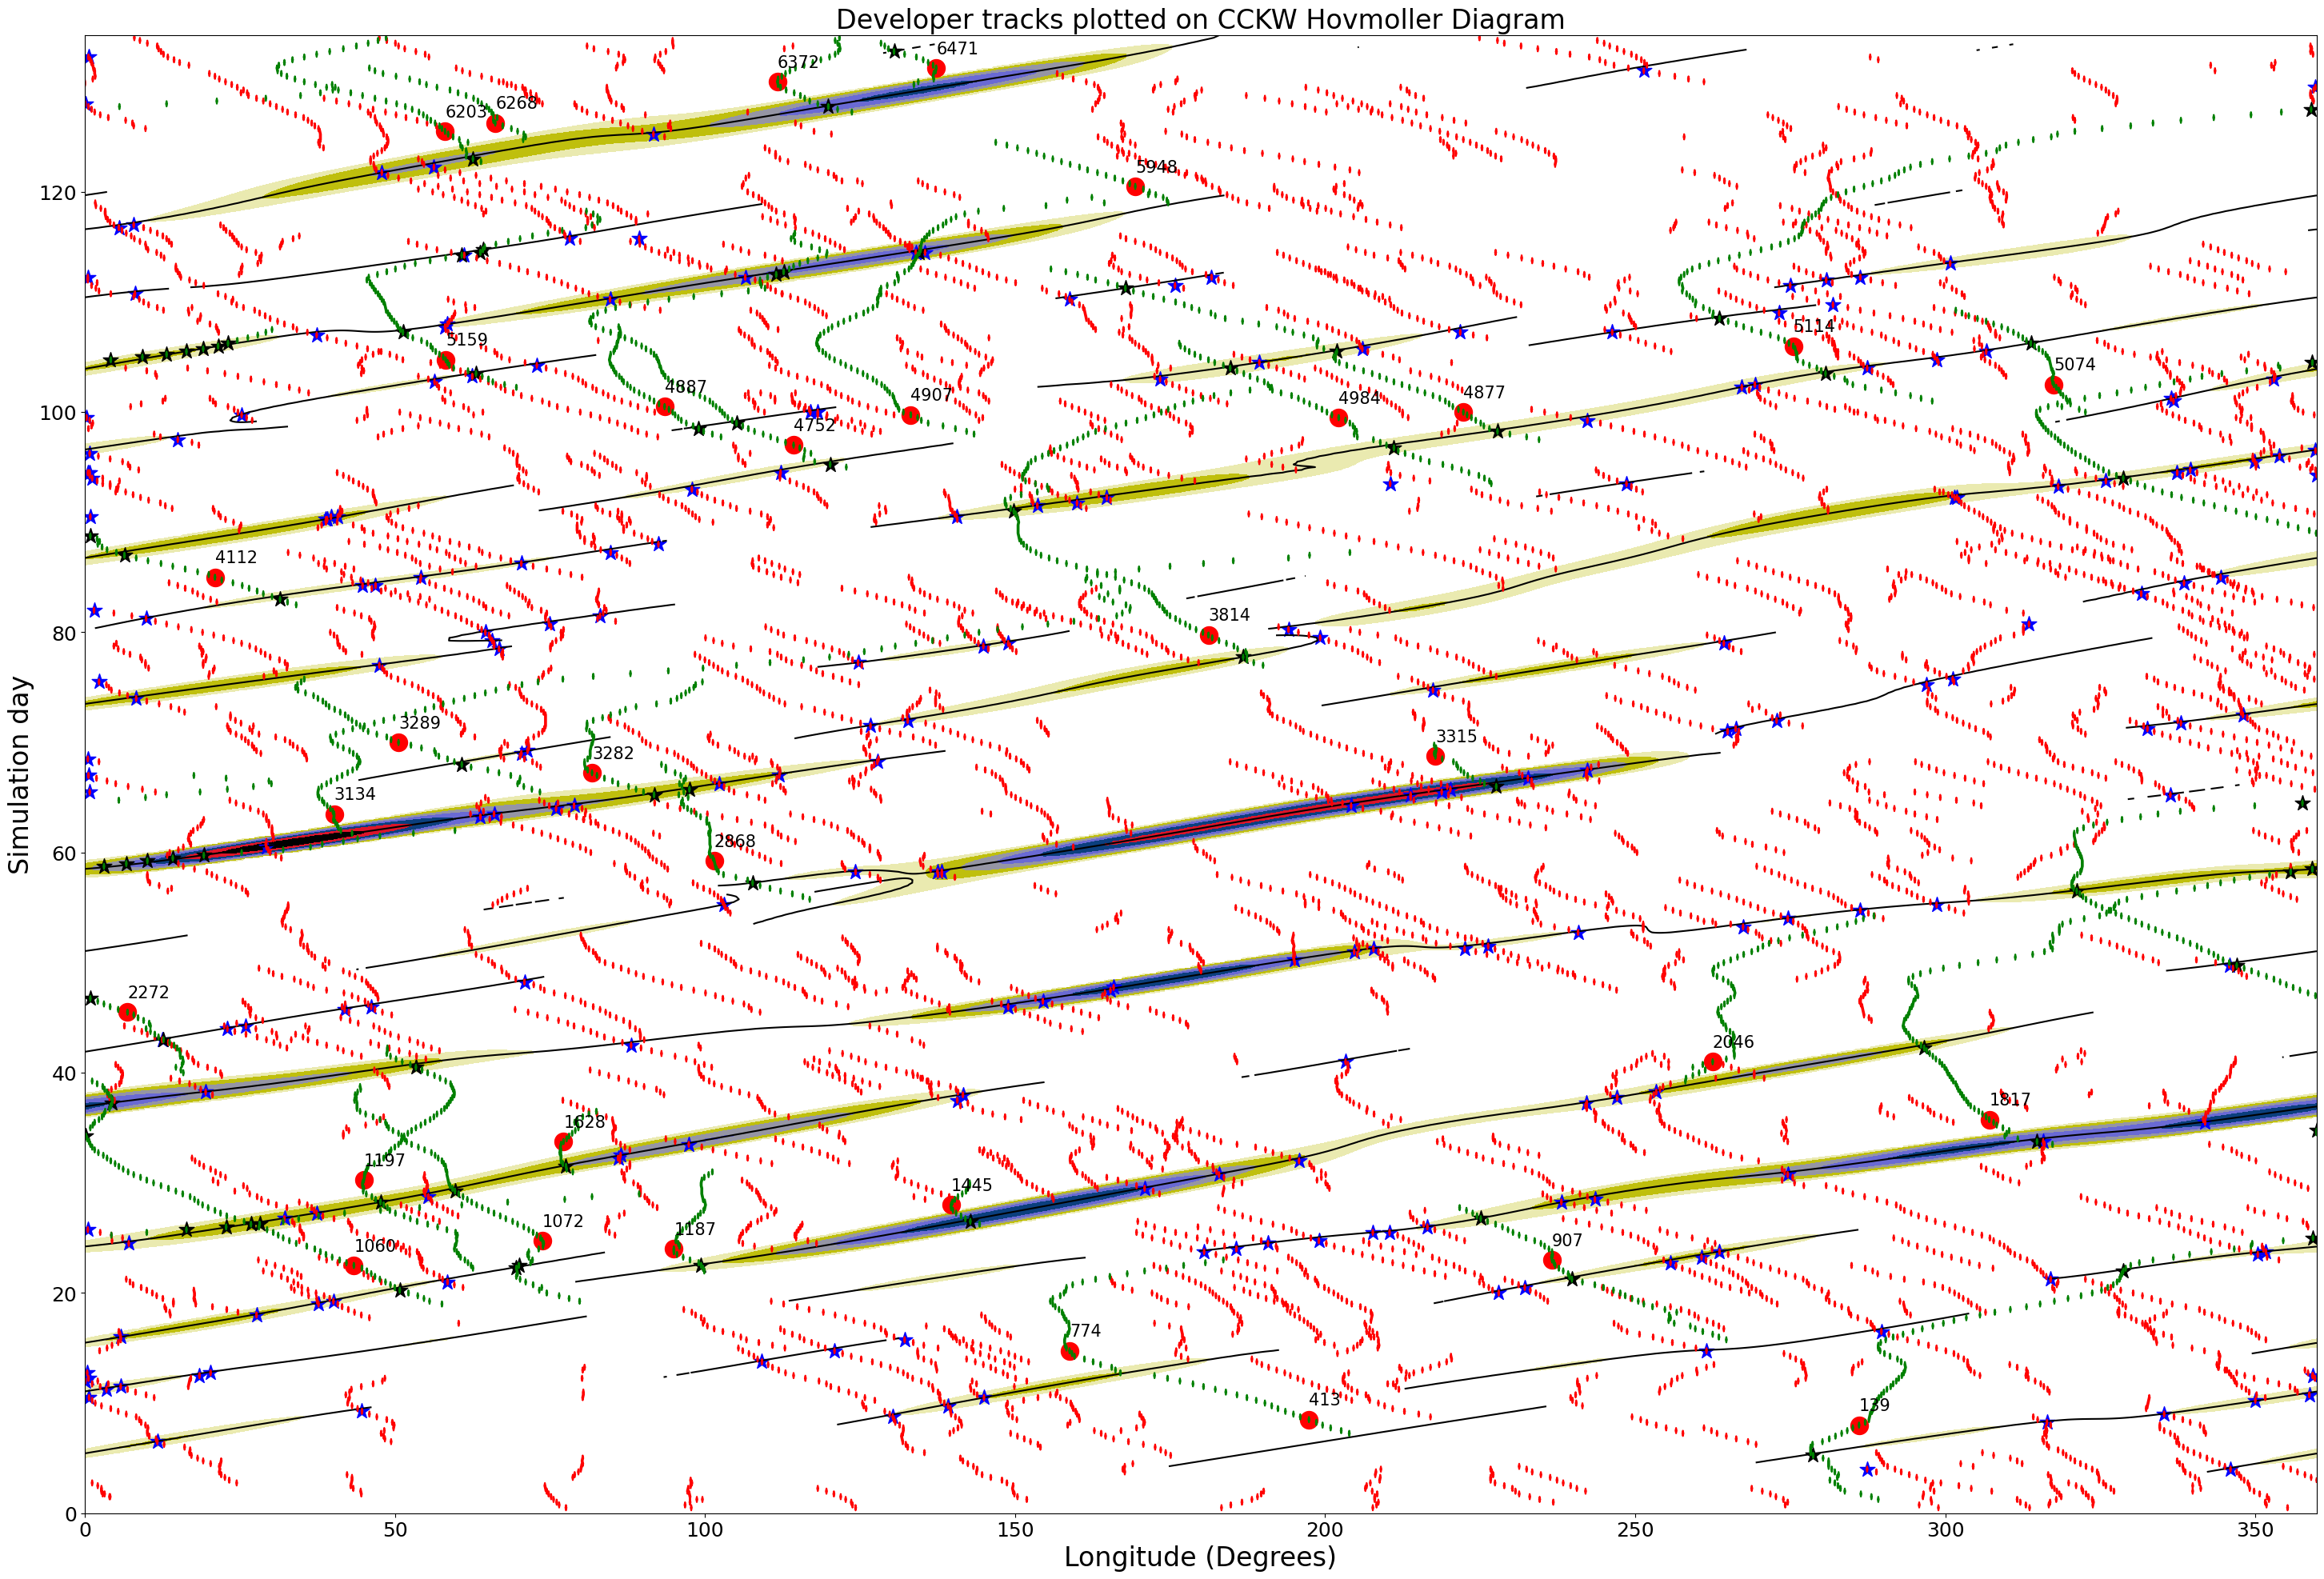

In [26]:
plt.figure(figsize=(36,24))  # Adjust the figure size as needed
cs = plt.contour(X,Y,waveDatadt_pos,levels=[0],colors='k')
plt.contourf(X,Y, waveData, extend='both',cmap='gist_stern_r')
plt.contour(X,Y,ndv_track,levels=[0],colors='r')
plt.contour(X,Y,dv_track,levels=[0],colors='g')



# Find the points where ndv_track_cckw_intersection equals 1
indices_ndv = np.where(np.isclose(ndv_track_cckw_intersection, 1))
indices_dv = np.where(np.isclose(dv_track_cckw_intersection, 1))
indices_tcgen = np.where(np.isclose(tcgen_dv, 1))

# Plot stars at these points
plt.scatter(X[indices_ndv], Y[indices_ndv], color='b', marker='*', s=200, label='ndv_track_cckw_intersection = 1')
plt.scatter(X[indices_dv], Y[indices_dv], color='k', marker='*', s=200, label='dv_track_cckw_intersection = 1')
plt.scatter(X[tcgen_idx_day,tcgen_idx_lon], Y[tcgen_idx_day,tcgen_idx_lon], color='r', marker='o', s=250)

# Add text labels next to each point
for i in range(len(tcgen_idx_day)):
   plt.text(X[tcgen_idx_day[i],tcgen_idx_lon[i]],Y[tcgen_idx_day[i]+7,tcgen_idx_lon[i]],tcgen_ID[i].astype(int).astype(str),fontsize=15, verticalalignment='center')

plt.xlabel('Longitude (Degrees)',fontsize=24) 
plt.ylabel('Simulation day',fontsize=24) 
plt.title('Developer tracks plotted on CCKW Hovmoller Diagram',fontsize=24) 
plt.xticks(fontsize=18)  # Increase font size of x-ticks
plt.yticks(fontsize=18)  # Increase font size of y-ticks


In [27]:
##The above tracking algorithm is being a bit problematic - look at what Rosi did instead of reinventing the wheel please. 

In [28]:
ndv_cckw_candidates = len(set(ndv_cckw_list))
ndv_cckw_candidates
#195 unique candidates

195

In [29]:
sum(eq_ndv_updated['cckw_crest_cross'])
#230 total interactions - lets treat this each interaction as a separate case! 

230.0

In [30]:
#Let's append the tcgenesis info to the eq_dv_updated dataframe 
eq_dv_updated

#Create new column associated with tropical cyclogenesis 
eq_dv_updated['tc_genesis'] = 0

eq_dv_updated.loc[(eq_dv_updated['ID'].isin(tcgen_ID)) &
       (eq_dv_updated['lon_TRACK'].isin(tcgen_lon)) &
       (eq_dv_updated['day_adj'].isin(tcgen_day)), 'tc_genesis'] = 1

In [31]:
np.sum(eq_dv_updated['tc_genesis']>0)

33

In [33]:
#Save off developers and nondeveloper timeseries data
#Eventually delete everything in the bottom once we have our separate script paradigm 

eq_dv_updated.to_csv("eq_dv_updated.csv", index=False)
eq_ndv_updated.to_csv("eq_ndv_updated.csv",index=False)

In [ ]:
#Ok great, it's 33 like we expect. Now let's generate histograms of time between CCKW crossing and tropical cyclogenesis - this should be a check to see if we're in the 1.5-3.5 day time frame as we expect 

eq_dv_updated_groupbyID = eq_dv_updated.groupby("ID")  # Group the 33 equatorial developers by ID

eq_dv_updated_groupbyID.head()

In [32]:
all_days_tc_gen_after_cckw = []
days_tc_gen_after_cckw = []

for ID, group in eq_dv_updated_groupbyID:

    days = group['day_adj']
    cckw_crest_cross = group['cckw_crest_cross']
    tc_genesis = group['tc_genesis']

    idx_cckw_crest_cross = np.where(cckw_crest_cross == 1)[0]
    idx_tc_genesis = np.where(tc_genesis == 1)[0]

    idx_cckw_preceding_tcgen = idx_cckw_crest_cross[idx_cckw_crest_cross < idx_tc_genesis]

    #If multiple cckw crossings prior to tcgen find the last crossing before tcgen
    if idx_cckw_preceding_tcgen.size>0: 
        idx_cckw_preceding_tcgen = idx_cckw_preceding_tcgen[-1] 

    #hack if the developer never technically interacts with the cckw, set the first track pt to be interaction
    if idx_cckw_preceding_tcgen.size==0:
        
        days_tc_gen_after_cckw = idx_tc_genesis/4 #6hr resolution 

    else: 
        
        days_tc_gen_after_cckw = (idx_tc_genesis - idx_cckw_preceding_tcgen)/4 #6hr resolution 

    all_days_tc_gen_after_cckw.append(days_tc_gen_after_cckw.item())

Text(0, 0.5, 'Frequency')

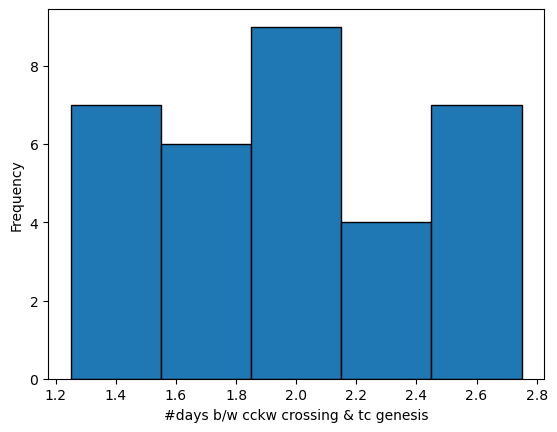

In [33]:
plt.hist(all_days_tc_gen_after_cckw, bins=5, edgecolor='black')
#These are a *hair* different than what Rosi got - but she's also doing it differently. 
#Maybe I should just have followed what she was doing....but go take a look later. 
#Does Rosi have a histogram of these values I can compare it to? 
plt.xlabel('#days b/w cckw crossing & tc genesis')
plt.ylabel('Frequency') 


In [34]:
#So outstanding problems thus far
#CCKW intersection algorithm for nondevelopers seems slightly off
#My algorithm I'm pretty sure isn't exactly what Rosi did - I should just replicate what she did - also some of my developers never "intersect" a wave but she found they did so there's a discrepancy somewhere 
#I don't know how Rosi generated her developers & nondevelopers, and it would be great to know that for my own benefit. 
#For my developers, they are slightly off in time I think compared to the established 1.5-3.5 day window. Again, I believe this to be an issue with the CCKW intersection algo
#Dealing with data truncation issues? For developers/nondevelopers, are we being consistent with keeping data within a certain latitude range from the equator? 
#General code cleanup 

In [35]:
#Work for AOSC650 - Can we predict whether TC genesis will occur based on the state of the tropical wave when it intersects with a CCKW? 

exp_name = 'TC_3km'
pth = "/glade/campaign/mmm/dpm/rberrios/glade_scratch/MPAS_APE/aqua_sstmax10N/%s/"%exp_name
fname = pth+'latlon/diags_gaussian_global_nospinup_r3600x1800.nc'
ds = xr.open_dataset(fname)
ds

<xarray.Dataset> Size: 90GB
Dimensions:   (time: 538, lon: 3600, lat: 552)
Coordinates:
  * time      (time) datetime64[ns] 4kB 2000-03-29T12:00:00 ... 2000-08-10T18...
  * lon       (lon) float64 29kB 0.0 0.1 0.2 0.3 0.4 ... 359.6 359.7 359.8 359.9
  * lat       (lat) float64 4kB -14.95 -14.85 -14.75 ... 39.95 40.05 40.15
Data variables: (12/21)
    rainc     (time, lat, lon) float32 4GB ...
    rainnc    (time, lat, lon) float32 4GB ...
    pr        (time, lat, lon) float32 4GB ...
    prc       (time, lat, lon) float32 4GB ...
    hfx       (time, lat, lon) float32 4GB ...
    mse_vint  (time, lat, lon) float32 4GB ...
    ...        ...
    u850      (time, lat, lon) float32 4GB ...
    ushr      (time, lat, lon) float32 4GB ...
    v10       (time, lat, lon) float32 4GB ...
    v200      (time, lat, lon) float32 4GB ...
    v850      (time, lat, lon) float32 4GB ...
    vshr      (time, lat, lon) float32 4GB ...
Attributes:
    Conventions:  CF-1.7

In [36]:
eq_dv_updated

,ID,fhr,valid_time,lon_TRACK,lat_TRACK,vor850,day_adj,cckw_crest_cross,tc_genesis
0,139,18.0,2000-03-30 18:00:00,289.227661,12.518373,1.662696,1.25,0.0,0
1,139,24.0,2000-03-31 00:00:00,288.096191,12.066323,1.480228,1.50,0.0,0
2,139,30.0,2000-03-31 06:00:00,286.437073,11.456782,1.368978,1.75,0.0,0
3,139,36.0,2000-03-31 12:00:00,283.840454,10.344266,1.408606,2.00,0.0,0
4,139,42.0,2000-03-31 18:00:00,283.081482,10.036515,1.418872,2.25,0.0,0
...,...,...,...,...,...,...,...,...,...
2001,6471,3174.0,2000-08-09 06:00:00,130.531494,7.102761,6.535087,132.75,1.0,0
2002,6471,3180.0,2000-08-09 12:00:00,129.574509,8.084695,7.502095,133.00,0.0,0
2003,6471,3186.0,2000-08-09 18:00:00,129.016266,9.367501,7.384973,133.25,0.0,0
2004,6471,3192.0,2000-08-10 00:00:00,128.399841,10.836242,7.083603,133.50,0.0,0


In [37]:
#This script extracts data from each developer for a given time in reference to it crossing a CCKW crest 

#It also adds a cckw crossing to the initial track data point for all developers that don't have any detected interactions with a CCKW. 
#This is done because technically all of the developers are registered to have interacted with a CCKW. I didn't fix this above when doing
#the plotting, maybe that gets fixed when I tweak the algorithm? So let's leave it here for now. 

#Get snapshot data on developers at X hours after cckw crossing ( can only be multiples of 6hrs and this may break if we go too far ahead)
#Current earliest development happens 1.25 days after crossing a CCKW crest so definitely stay behind that! 

dt_cckw_cross_hrs = 12 # THIS WILL BE USED FOR BOTH THE DEVELOPERS AND NON-DEVELOPERS (SEE NEXT CODE BLOCK) 

def divide_and_check(x):
    result = x // 6  # Floor division: keeps only whole-number part, no remainder
    if result > 4:
        raise ValueError(f"Result {result} is greater than 1 day out into the future.")
    return result

def get_last_cckw_or_set_first(group,dt_cckw_cross):
    group = group.reset_index(drop=True)
    genesis_rows = group.index[group['tc_genesis'] == 1]

    # If no genesis, return nothing
    if len(genesis_rows) == 0:
        return pd.DataFrame()

    genesis_idx = genesis_rows[0]

    # Subset only before genesis
    pre_genesis = group.iloc[:genesis_idx]

    # Find rows with cckw_crest_cross == 1 before genesis
    cckw_rows = pre_genesis[pre_genesis['cckw_crest_cross'] == 1]
    
    # Get corresponding indices in original data frame
    cckw_indices = cckw_rows.index
    
    if not cckw_rows.empty:
        # If there are crossings before genesis, return the last crossing
        
        #row = cckw_rows.iloc[[-1]]
        last_cckw_crossing_idx = cckw_indices[-1]
        dt_idx = divide_and_check(dt_cckw_cross_hrs)
         

        return pre_genesis.iloc[[last_cckw_crossing_idx+dt_idx],:]

    else:
        # If no crossings found, FORCE first row to have crossing = 1
        group.loc[0, 'cckw_crest_cross'] = 1
        dt_idx = divide_and_check(dt_cckw_cross_hrs)

        return group.iloc[[0+dt_idx]]

eq_dv_cckw = (
    eq_dv_updated
    .groupby('ID', group_keys=False)
    .apply(lambda group: get_last_cckw_or_set_first(group, dt_cckw_cross_hrs))
    .reset_index(drop=True)
)
eq_dv_cckw['developer'] = 1
eq_dv_cckw



/glade/derecho/scratch/sjsharma/tmp/ipykernel_52333/270212438.py:57: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: get_last_cckw_or_set_first(group, dt_cckw_cross_hrs))


,ID,fhr,valid_time,lon_TRACK,lat_TRACK,vor850,day_adj,cckw_crest_cross,tc_genesis,developer
0,139,126.0,2000-04-04 06:00:00,278.290375,7.665624,3.883170,5.75,0.0,0,1
1,413,174.0,2000-04-06 06:00:00,200.918625,6.624130,1.269772,7.75,0.0,0,1
2,774,306.0,2000-04-11 18:00:00,165.557419,10.081467,4.100011,13.25,0.0,0,1
3,907,510.0,2000-04-20 06:00:00,239.245956,8.287936,2.908435,21.75,0.0,0,1
4,1060,486.0,2000-04-19 06:00:00,49.256882,7.146198,3.211394,20.75,0.0,0,1
5,1072,540.0,2000-04-21 12:00:00,72.205605,9.176808,3.175312,23.00,0.0,0,1
6,1187,540.0,2000-04-21 12:00:00,97.643509,5.988581,2.356625,23.00,0.0,0,1
7,1197,678.0,2000-04-27 06:00:00,46.275898,10.331858,2.624203,28.75,0.0,0,1
8,1445,636.0,2000-04-25 12:00:00,141.293350,4.176076,2.967266,27.00,0.0,0,1
9,1628,756.0,2000-04-30 12:00:00,76.787048,10.181087,2.775074,32.00,0.0,0,1


In [38]:
#Now let's extract the data associated with cckw crest crossing for nondevelopers!
eq_ndv_cckw_raw = eq_ndv_updated[eq_ndv_updated['cckw_crest_cross']==1]

eq_ndv_cckw_group = eq_ndv_cckw_raw.sort_values("valid_time").groupby("ID").apply(lambda g: g.iloc[[0]])
original_indices = eq_ndv_cckw_group.index.get_level_values(1)

#Since time increases by 0.25 days (6 hrs) between data points, can modify indices directly when adjusting for time after cckw crest cross 
shifted_indices = original_indices + divide_and_check(dt_cckw_cross_hrs)


print(original_indices)
print(shifted_indices)

Index([   8,   96,  129,  273,  341,  387,  432,  531,  538,  572,
       ...
       6870, 6896, 6957, 7150, 7295, 7310, 7360, 7456, 7497, 7638],
      dtype='int64', length=195)
Index([  10,   98,  131,  275,  343,  389,  434,  533,  540,  574,
       ...
       6872, 6898, 6959, 7152, 7297, 7312, 7362, 7458, 7499, 7640],
      dtype='int64', length=195)


/glade/derecho/scratch/sjsharma/tmp/ipykernel_52333/1223496190.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  eq_ndv_cckw_group = eq_ndv_cckw_raw.sort_values("valid_time").groupby("ID").apply(lambda g: g.iloc[[0]])


In [39]:
#get nondeveloper data with time shift dt from cckw crossing 
eq_ndv_cckw = eq_ndv_updated.iloc[shifted_indices]


In [40]:
eq_ndv_cckw

,ID,fhr,valid_time,lon_TRACK,lat_TRACK,vor850,day_adj,cckw_crest_cross
10,5,156.0,2000-04-05 12:00:00,10.398719,17.818823,1.644088,7.00,0.0
98,68,0.0,2000-03-30 00:00:00,313.648956,18.921946,2.412342,0.50,0.0
131,81,96.0,2000-04-03 00:00:00,344.240356,11.836883,2.482649,4.50,0.0
275,180,198.0,2000-04-07 06:00:00,314.186462,17.792263,2.626634,8.75,0.0
343,320,210.0,2000-04-07 18:00:00,128.977661,10.118465,2.164372,9.25,0.0
...,...,...,...,...,...,...,...,...
7312,6073,2832.0,2000-07-26 00:00:00,264.516174,19.692669,2.570610,118.50,0.0
7362,6113,2748.0,2000-07-22 12:00:00,133.446457,13.798036,0.802940,115.00,0.0
7458,6279,3006.0,2000-08-02 06:00:00,88.441101,4.081156,1.713228,125.75,0.0
7499,6302,3072.0,2000-08-05 00:00:00,359.190125,5.430201,1.462137,128.50,0.0


In [41]:
#Now let's merge these two data frames together. 
#Let's also rename some of the columns to be consistent with the simulation's xarray dataset

merged_cckw = pd.concat([eq_dv_cckw, eq_ndv_cckw], ignore_index=True)
merged_cckw.fillna(0,inplace=True)
merged_cckw.rename(columns={"lon_TRACK": "lon", "lat_TRACK": "lat", "valid_time":"time"}, inplace=True)


In [42]:
merged_cckw

,ID,fhr,time,lon,lat,vor850,day_adj,cckw_crest_cross,tc_genesis,developer
0,139,126.0,2000-04-04 06:00:00,278.290375,7.665624,3.883170,5.75,0.0,0.0,1.0
1,413,174.0,2000-04-06 06:00:00,200.918625,6.624130,1.269772,7.75,0.0,0.0,1.0
2,774,306.0,2000-04-11 18:00:00,165.557419,10.081467,4.100011,13.25,0.0,0.0,1.0
3,907,510.0,2000-04-20 06:00:00,239.245956,8.287936,2.908435,21.75,0.0,0.0,1.0
4,1060,486.0,2000-04-19 06:00:00,49.256882,7.146198,3.211394,20.75,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...
223,6073,2832.0,2000-07-26 00:00:00,264.516174,19.692669,2.570610,118.50,0.0,0.0,0.0
224,6113,2748.0,2000-07-22 12:00:00,133.446457,13.798036,0.802940,115.00,0.0,0.0,0.0
225,6279,3006.0,2000-08-02 06:00:00,88.441101,4.081156,1.713228,125.75,0.0,0.0,0.0
226,6302,3072.0,2000-08-05 00:00:00,359.190125,5.430201,1.462137,128.50,0.0,0.0,0.0


In [43]:
#Now let's add key variable anomalies that may be predictive of tc genesis at the track's center. Let's make sure we do this systematically! 

#Key variables (for now)
key_vars ={'olrtoa','mse_vint','u200','v200','u850','v850','qv_vint'}

#What I want to do: 
#1) For each row in merged_cckw, find nearest lat-lon-time data point 
#2) Find the value of the key variables at that point in space and time 
#3) Anomalies must be created - we can do this by averaging all the data points at that latitude (for all longtiude and time values) for those key variables 
#4) Add those anomaly columns to the merged_cckw dataframe 


In [44]:
exp_name = 'TC_3km'
pth = "/glade/campaign/mmm/dpm/rberrios/glade_scratch/MPAS_APE/aqua_sstmax10N/%s/"%exp_name
fname = pth+'latlon/diags_gaussian_global_nospinup_r3600x1800.nc'
ds = xr.open_dataset(fname)
ds

<xarray.Dataset> Size: 90GB
Dimensions:   (time: 538, lon: 3600, lat: 552)
Coordinates:
  * time      (time) datetime64[ns] 4kB 2000-03-29T12:00:00 ... 2000-08-10T18...
  * lon       (lon) float64 29kB 0.0 0.1 0.2 0.3 0.4 ... 359.6 359.7 359.8 359.9
  * lat       (lat) float64 4kB -14.95 -14.85 -14.75 ... 39.95 40.05 40.15
Data variables: (12/21)
    rainc     (time, lat, lon) float32 4GB ...
    rainnc    (time, lat, lon) float32 4GB ...
    pr        (time, lat, lon) float32 4GB ...
    prc       (time, lat, lon) float32 4GB ...
    hfx       (time, lat, lon) float32 4GB ...
    mse_vint  (time, lat, lon) float32 4GB ...
    ...        ...
    u850      (time, lat, lon) float32 4GB ...
    ushr      (time, lat, lon) float32 4GB ...
    v10       (time, lat, lon) float32 4GB ...
    v200      (time, lat, lon) float32 4GB ...
    v850      (time, lat, lon) float32 4GB ...
    vshr      (time, lat, lon) float32 4GB ...
Attributes:
    Conventions:  CF-1.7

In [45]:
# -----------------------------
# Step 0. Load your data
# -----------------------------
# Open the input dataset (assumes your infile is in a NetCDF-like format)

# The key variables
key_vars = {'olrtoa', 'mse_vint', 'u200', 'v200', 'u850', 'v850', 'qv_vint'}

# -----------------------------
# Step 1. Identify latitudes of interest
# -----------------------------
# Extract unique latitudes from merged_cckw
lat_interest = np.unique(merged_cckw['lat'])
# Print for debugging:
print("Latitudes of interest:", lat_interest)


Latitudes of interest: [ 0.711598  2.242109  2.623042  2.649361  2.71724   3.040493  3.046459
  3.078763  3.59643   3.642919  3.763321  3.927901  3.962895  4.033937
  4.081156  4.176076  4.287381  4.291056  4.392898  4.433673  4.45719
  4.475161  4.701426  4.786369  4.864817  4.915434  5.199242  5.218291
  5.297218  5.401896  5.42718   5.430201  5.461466  5.563728  5.654129
  5.742009  5.746299  5.822849  5.830569  5.876845  5.893012  5.988581
  6.00392   6.076843  6.09637   6.112267  6.164096  6.187971  6.189862
  6.213946  6.227264  6.509685  6.548475  6.563504  6.564182  6.605021
  6.62413   6.643809  6.75286   6.753565  6.866037  6.871519  6.957836
  6.972727  6.991948  7.014703  7.029647  7.04458   7.056722  7.09214
  7.094355  7.103897  7.135282  7.146198  7.174515  7.257901  7.405
  7.411413  7.603684  7.605731  7.660512  7.665624  7.789275  7.858216
  7.866118  7.973677  8.26564   8.287936  8.327587  8.420562  8.428722
  8.660897  8.702502  8.759752  8.776347  8.845424  8.91397

In [46]:
#So this could use some work. First, I should run this for the entire dataset so I have values at all latitudes. Then I need to best map the latitudes of interest to this. 


# # -----------------------------
# # Step 2. Compute background means only for these latitudes
# # -----------------------------
# # Create a dictionary to hold the background (mean) for each variable
# avg_dict = {}
# for var in key_vars:
#     # Compute the mean over time and lon, then select only latitudes of interest
#     avg_mean = ds[var].mean(dim=['time', 'lon'])
#     # Only take values corresponding to latitudes of interest 
#     # (using method='nearest' to match if the latitudes don't exactly coincide)
#     avg_dict[var] = avg_mean.sel(lat=lat_interest, method='nearest')

#SAVE OFF AS NETCDF! 

In [47]:
#load key variables averages dataset generated previously 
avg_ds = xr.open_dataset('avg_values_aquaplanet.nc')

# Step 1: Get the latitude values
lat_vals = avg_ds['lat'].values

# Step 2: Identify unique latitudes and their first index positions
_, unique_indices = np.unique(lat_vals, return_index=True)

# Step 3: Sort those indices to preserve original order
unique_indices_sorted = np.sort(unique_indices)

# Step 4: Select only those unique indices along the lat dimension
avg_ds_non_duplicated = avg_ds.isel(lat=unique_indices_sorted)

avg_ds_non_duplicated

<xarray.Dataset> Size: 5kB
Dimensions:   (lat: 128)
Coordinates:
  * lat       (lat) float64 1kB 0.85 2.35 2.95 3.05 ... 19.65 19.75 19.85 19.95
Data variables:
    mse_vint  (lat) float32 512B ...
    u200      (lat) float32 512B ...
    v850      (lat) float32 512B ...
    u850      (lat) float32 512B ...
    v200      (lat) float32 512B ...
    qv_vint   (lat) float32 512B ...
    olrtoa    (lat) float32 512B ...

In [48]:
# Assume these variables are already defined:
#   merged_cckw: your existing DataFrame
#   ds: your xarray dataset
#   key_vars: list of variable names, e.g.,
#       key_vars = ['olrtoa', 'mse_vint', 'u200', 'v200', 'u850', 'v850', 'qv_vint']

def get_raw_values(row):
    values = {}
    for var in key_vars:
        try:
            # Select the nearest point from ds using the values in the current row
            point_val = ds[var].sel(
                time=row['time'],
                lat=row['lat'],
                lon=row['lon'],
                method='nearest'
            ).values.item()
            
            # Save the value with a new column name: var'
            values[var] = point_val
        
        except Exception as e:
            print(f"Error for variable {var} at row {row.name}: {e}")
            values[var] = np.nan  # In case of error, fill with NaN
    return pd.Series(values)

# Apply the function row-wise to create a DataFrame of the raw values
raw_values_df = merged_cckw.apply(get_raw_values, axis=1)

# Append these new columns to the original merged_cckw DataFrame
merged_cckw_with_features = pd.concat([merged_cckw, raw_values_df], axis=1)

# Show the first few rows of the updated DataFrame to verify:
print(merged_cckw_with_features.head())


     ID    fhr                 time         lon        lat    vor850  day_adj  \
0   139  126.0  2000-04-04 06:00:00  278.290375   7.665624  3.883170     5.75   
1   413  174.0  2000-04-06 06:00:00  200.918625   6.624130  1.269772     7.75   
2   774  306.0  2000-04-11 18:00:00  165.557419  10.081467  4.100011    13.25   
3   907  510.0  2000-04-20 06:00:00  239.245956   8.287936  2.908435    21.75   
4  1060  486.0  2000-04-19 06:00:00   49.256882   7.146198  3.211394    20.75   

   cckw_crest_cross  tc_genesis  developer      mse_vint      olrtoa  \
0               0.0         0.0        1.0  3.124474e+09  130.258636   
1               0.0         0.0        1.0  3.140838e+09  245.152283   
2               0.0         0.0        1.0  3.144216e+09  189.319046   
3               0.0         0.0        1.0  3.144059e+09  122.859886   
4               0.0         0.0        1.0  3.148269e+09  107.217049   

       v850    qv_vint      v200       u200      u850  
0  1.988736  52.668739  

In [49]:
# Assume key_vars and the function get_lat_means are defined as follows:
key_vars = ['mse_vint', 'u200', 'v200', 'u850', 'v850', 'qv_vint', 'olrtoa']

def get_lat_means(row):
    values = {}
    for var in key_vars:
        try:
            mean_val = avg_ds_non_duplicated[var].sel(lat=row['lat'], method='nearest').values.item()
            values[var + '_mean'] = mean_val
        except Exception as e:
            print(f"Error for variable {var} at row {row.name}: {e}")
            values[var + '_mean'] = np.nan
    return pd.Series(values)

# Instead of overwriting merged_cckw, create a new DataFrame for mean values:
means_df = merged_cckw_with_features.apply(get_lat_means, axis=1)

# Now, append the new columns to the original merged_cckw:
merged_cckw_full = pd.concat([merged_cckw_with_features, means_df], axis=1)

print(merged_cckw_full.head())



     ID    fhr                 time         lon        lat    vor850  day_adj  \
0   139  126.0  2000-04-04 06:00:00  278.290375   7.665624  3.883170     5.75   
1   413  174.0  2000-04-06 06:00:00  200.918625   6.624130  1.269772     7.75   
2   774  306.0  2000-04-11 18:00:00  165.557419  10.081467  4.100011    13.25   
3   907  510.0  2000-04-20 06:00:00  239.245956   8.287936  2.908435    21.75   
4  1060  486.0  2000-04-19 06:00:00   49.256882   7.146198  3.211394    20.75   

   cckw_crest_cross  tc_genesis  developer  ...      v200       u200  \
0               0.0         0.0        1.0  ...  4.198910  -1.255961   
1               0.0         0.0        1.0  ...  5.466361 -15.660344   
2               0.0         0.0        1.0  ... -4.151650  -3.776478   
3               0.0         0.0        1.0  ... -5.393417  -3.411160   
4               0.0         0.0        1.0  ... -1.759143 -12.588780   

       u850  mse_vint_mean  u200_mean  v200_mean  u850_mean  v850_mean  \
0  2.2

In [50]:
# List of key variable names (should match your previous definitions)
key_vars = ['mse_vint', 'u200', 'v200', 'u850', 'v850', 'qv_vint', 'olrtoa']

# Loop over each variable and create a new column for the anomaly
for var in key_vars:
    actual_col = var
    mean_col = var + '_mean'
    anomaly_col = var + '_anomaly'
    
    # Check that both the actual and mean columns exist in merged_cckw
    if actual_col in merged_cckw_full.columns and mean_col in merged_cckw_full.columns:
        merged_cckw_full[anomaly_col] = merged_cckw_full[actual_col] - merged_cckw_full[mean_col]
    else:
        print(f"Column missing: {actual_col} or {mean_col}")

# Verify the result
print(merged_cckw_full.head())



     ID    fhr                 time         lon        lat    vor850  day_adj  \
0   139  126.0  2000-04-04 06:00:00  278.290375   7.665624  3.883170     5.75   
1   413  174.0  2000-04-06 06:00:00  200.918625   6.624130  1.269772     7.75   
2   774  306.0  2000-04-11 18:00:00  165.557419  10.081467  4.100011    13.25   
3   907  510.0  2000-04-20 06:00:00  239.245956   8.287936  2.908435    21.75   
4  1060  486.0  2000-04-19 06:00:00   49.256882   7.146198  3.211394    20.75   

   cckw_crest_cross  tc_genesis  developer  ...  v850_mean  qv_vint_mean  \
0               0.0         0.0        1.0  ...   0.044413     51.662514   
1               0.0         0.0        1.0  ...   0.311836     52.612240   
2               0.0         0.0        1.0  ...  -0.255557     48.901531   
3               0.0         0.0        1.0  ...  -0.068901     51.021912   
4               0.0         0.0        1.0  ...   0.167605     52.156933   

   olrtoa_mean  mse_vint_anomaly  u200_anomaly  v200_ano

In [51]:
# List the key variable column names as features
feature_cols = ['olrtoa_anomaly', 'u200_anomaly', 'v200_anomaly', 'u850_anomaly', 'v850_anomaly', 'vor850','qv_vint_anomaly']
target_col = 'developer'

# Create feature matrix X and target vector y
X = merged_cckw_full[feature_cols]

y = merged_cckw_full[target_col]

#Delete redundant columns if there are redundant columns 
merged_cckw_full = merged_cckw_full.loc[:, ~merged_cckw_full.columns.duplicated()]

print(merged_cckw_full.columns)


Index(['ID', 'fhr', 'time', 'lon', 'lat', 'vor850', 'day_adj',
       'cckw_crest_cross', 'tc_genesis', 'developer', 'mse_vint', 'olrtoa',
       'v850', 'qv_vint', 'v200', 'u200', 'u850', 'mse_vint_mean', 'u200_mean',
       'v200_mean', 'u850_mean', 'v850_mean', 'qv_vint_mean', 'olrtoa_mean',
       'mse_vint_anomaly', 'u200_anomaly', 'v200_anomaly', 'u850_anomaly',
       'v850_anomaly', 'qv_vint_anomaly', 'olrtoa_anomaly'],
      dtype='object')


In [54]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # This gives you a NumPy array

#DOUBLE CHECK THIS IS APPLIED TO EACH COLUMN SEPARATELY 

In [55]:
# 60-40 split: 60% training and 40% validation (or test)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.4, random_state=42, stratify=y)

In [56]:
X_scaled = pd.DataFrame(X_scaled, columns=feature_cols, index=X.index)

In [57]:
X_scaled.describe()

,olrtoa_anomaly,u200_anomaly,v200_anomaly,u850_anomaly,v850_anomaly,vor850,qv_vint_anomaly
count,2.280000e+02,2.280000e+02,2.280000e+02,2.280000e+02,2.280000e+02,2.280000e+02,2.280000e+02
mean,3.116416e-17,3.116416e-17,4.869399e-18,-3.895519e-18,-7.791039e-18,6.232831e-17,-3.116416e-17
std,1.002200e+00,1.002200e+00,1.002200e+00,1.002200e+00,1.002200e+00,1.002200e+00,1.002200e+00
min,-2.903699e+00,-3.674939e+00,-3.667274e+00,-2.776334e+00,-2.537154e+00,-1.424743e+00,-3.384286e+00
25%,-4.871106e-01,-6.668676e-01,-4.411541e-01,-6.171142e-01,-7.699763e-01,-7.726739e-01,-6.638370e-01
50%,4.062882e-01,-8.732003e-02,1.564982e-02,-3.794739e-02,-5.906176e-02,-1.680523e-01,1.877105e-01
75%,6.998971e-01,5.976070e-01,6.445976e-01,6.193015e-01,6.631989e-01,6.107469e-01,7.575024e-01
max,1.270620e+00,2.615565e+00,2.997084e+00,3.252269e+00,3.239794e+00,3.386964e+00,2.172588e+00


In [62]:
model = () 

def set_seeds(seed_value=42):
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)

# Determine the input dimension (# of features)
input_dim = X_train.shape[1]

set_seeds(42)

model = Sequential([
    tf.keras.layers.Input(shape=(input_dim,)),
    Dense(8, activation='relu', name='input'),
    Dense(2, activation='relu', name='hidden_layer_3'),
    Dense(1, activation='sigmoid', name='output_layer')  # Sigmoid for binary classification.
])

# Create an optimizer with a custom learning rate
optimizer = Adam(learning_rate=0.0045)   # <-- Set your learning rate here

# Then compile your model using this optimizer
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Assuming y_train contains your training labels
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, class_weights))
print("Class weights:", class_weight_dict)
#class_weight_dict = {0.0: 0.5, 1.0: 5} #alt weights
set_seeds(42)

# Fit the model using class weights
history = model.fit(X_train, y_train,
                    epochs=125,
                    batch_size=32,
                    validation_data=(X_test, y_test),
                    class_weight=class_weight_dict,
                    verbose=1,shuffle=True)

Class weights: {0.0: 0.5862068965517241, 1.0: 3.4}
Epoch 1/125
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.2824 - loss: 0.8413 - val_accuracy: 0.3696 - val_loss: 0.9104
Epoch 2/125
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3698 - loss: 0.8000 - val_accuracy: 0.4130 - val_loss: 0.8548
Epoch 3/125
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4455 - loss: 0.7722 - val_accuracy: 0.4239 - val_loss: 0.8118
Epoch 4/125
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5114 - loss: 0.7541 - val_accuracy: 0.4457 - val_loss: 0.7789
Epoch 5/125
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5591 - loss: 0.7425 - val_accuracy: 0.5217 - val_loss: 0.7556
Epoch 6/125
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5961 - loss: 0.7347 - val_accuracy: 0.5543 - val_loss: 0.7393
Epoch 7/125
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6328 - loss: 0.7286 - val_accuracy: 0.5761 - val_loss: 0.7288
Epoch 8/125
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.678

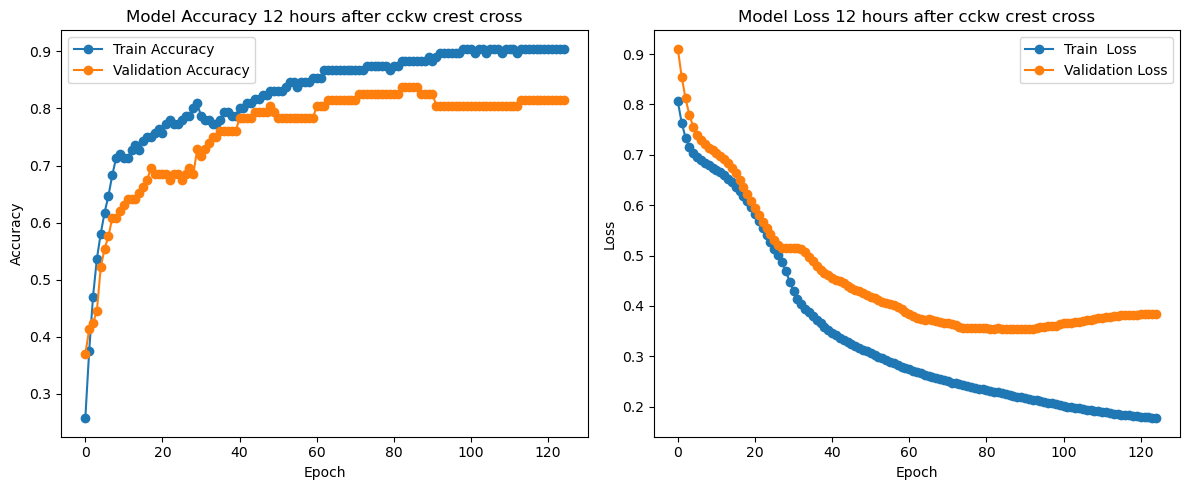

In [63]:
# --- Plot Accuracy and Loss ---
plt.figure(figsize=(12, 5))

# Accuracy subplot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title(f'Model Accuracy {dt_cckw_cross_hrs} hours after cckw crest cross')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss subplot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train  Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title(f'Model Loss {dt_cckw_cross_hrs} hours after cckw crest cross')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [64]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss:.3f}, Test Accuracy: {accuracy:.3f}")

Test Loss: 0.384, Test Accuracy: 0.815


In [65]:
# Assuming y_test is your test target Series
print("Test set class distribution:")
print(y_test.value_counts())

Test set class distribution:
developer
0.0    79
1.0    13
Name: count, dtype: int64


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Test set class distribution:
developer
0.0    79
1.0    13
Name: count, dtype: int64


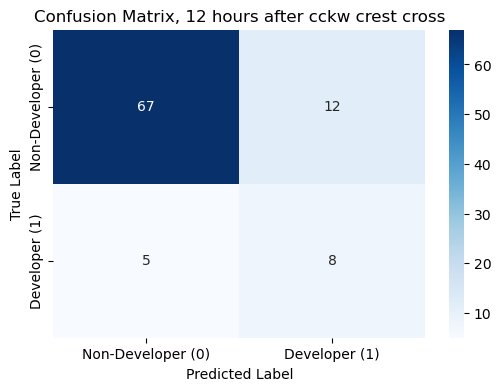

Classification Report:
               precision    recall  f1-score   support

Non-Developer       0.93      0.85      0.89        79
    Developer       0.40      0.62      0.48        13

     accuracy                           0.82        92
    macro avg       0.67      0.73      0.69        92
 weighted avg       0.86      0.82      0.83        92



In [66]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# --- Generate Predictions ---
# Predict the probabilities on the test set. 
# Note: For binary classification with a sigmoid output, the output is a probability.
y_pred_probs = model.predict(X_test)

# Convert probabilities to binary predictions using a threshold (default 0.5)
y_pred = (y_pred_probs > 0.5).astype(int)

# If your predictions are in a 2D array (e.g., shape (n, 1)) you might want to flatten them:
y_pred = y_pred.ravel()

# --- Examine Distribution in the Test Set ---
print("Test set class distribution:")
print(y_test.value_counts())

# --- Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Non-Developer (0)', 'Developer (1)'],
            yticklabels=['Non-Developer (0)', 'Developer (1)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix, {dt_cckw_cross_hrs} hours after cckw crest cross')
plt.show()

# --- Classification Report ---
report = classification_report(y_test, y_pred, target_names=['Non-Developer', 'Developer'])
print("Classification Report:")
print(report)


In [68]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.4, random_state=42, stratify=y)

In [69]:
y_pred_series = pd.Series(
    y_pred,
    index=y_test.index,
    name='y_pred'
)


fp_idx = y_pred_series[(y_pred_series == 1) & (y_test == 0)].index
fn_idx = y_pred_series[(y_pred_series == 0) & (y_test == 1)].index

print(fp_idx)
print(fn_idx)

fp_df = X_test.loc[fp_idx].copy()
fn_df = X_test.loc[fn_idx].copy()
fp_df['error_type'] = 'False Positive'
fn_df['error_type'] = 'False Negative'
fp_df['sample_id']  = fp_df.index.astype(str)   # string so seaborn treats it categorically
fn_df['sample_id']  = fn_df.index.astype(str)

# Combine them
mis_df = pd.concat([fp_df, fn_df], axis=0)



# Melt so you get one row per sample×variable
mis_melted = mis_df.melt(
    id_vars=['error_type','sample_id'],
    value_vars=list(feature_cols),
    var_name='Variable',
    value_name='Anomaly Value'
)

mis_melted

Index([209, 80, 222, 46, 221, 85, 139, 135, 107, 190, 87, 34], dtype='int64')
Index([0, 26, 28, 29, 1], dtype='int64')


,error_type,sample_id,Variable,Anomaly Value
0,False Positive,209,olrtoa_anomaly,0.272255
1,False Positive,80,olrtoa_anomaly,-0.947543
2,False Positive,222,olrtoa_anomaly,0.712459
3,False Positive,46,olrtoa_anomaly,0.212484
4,False Positive,221,olrtoa_anomaly,-0.495606
...,...,...,...,...
114,False Negative,0,qv_vint_anomaly,0.120959
115,False Negative,26,qv_vint_anomaly,0.601577
116,False Negative,28,qv_vint_anomaly,0.627873
117,False Negative,29,qv_vint_anomaly,0.991197


In [70]:
mis_melted['Scaled'] = (
    mis_melted
      .groupby('Variable')['Anomaly Value']
      .transform(lambda x: (x - x.mean()) / x.std())
)

# First map 0 -> 'Non-Developer', 1 -> 'Developer'
merged_cckw_full['developer_label'] = merged_cckw_full['developer'].map({0: 'Non-Developer', 1: 'Developer'})
# Melt

melted = merged_cckw_full.melt(id_vars='developer_label', value_vars=X_test,var_name='Variable', value_name='Anomaly Value')

# after you’ve created your `melted` DataFrame:

melted['Scaled'] = (
    melted
      .groupby('Variable')['Anomaly Value']
      .transform(lambda x: (x - x.mean()) / x.std())
)



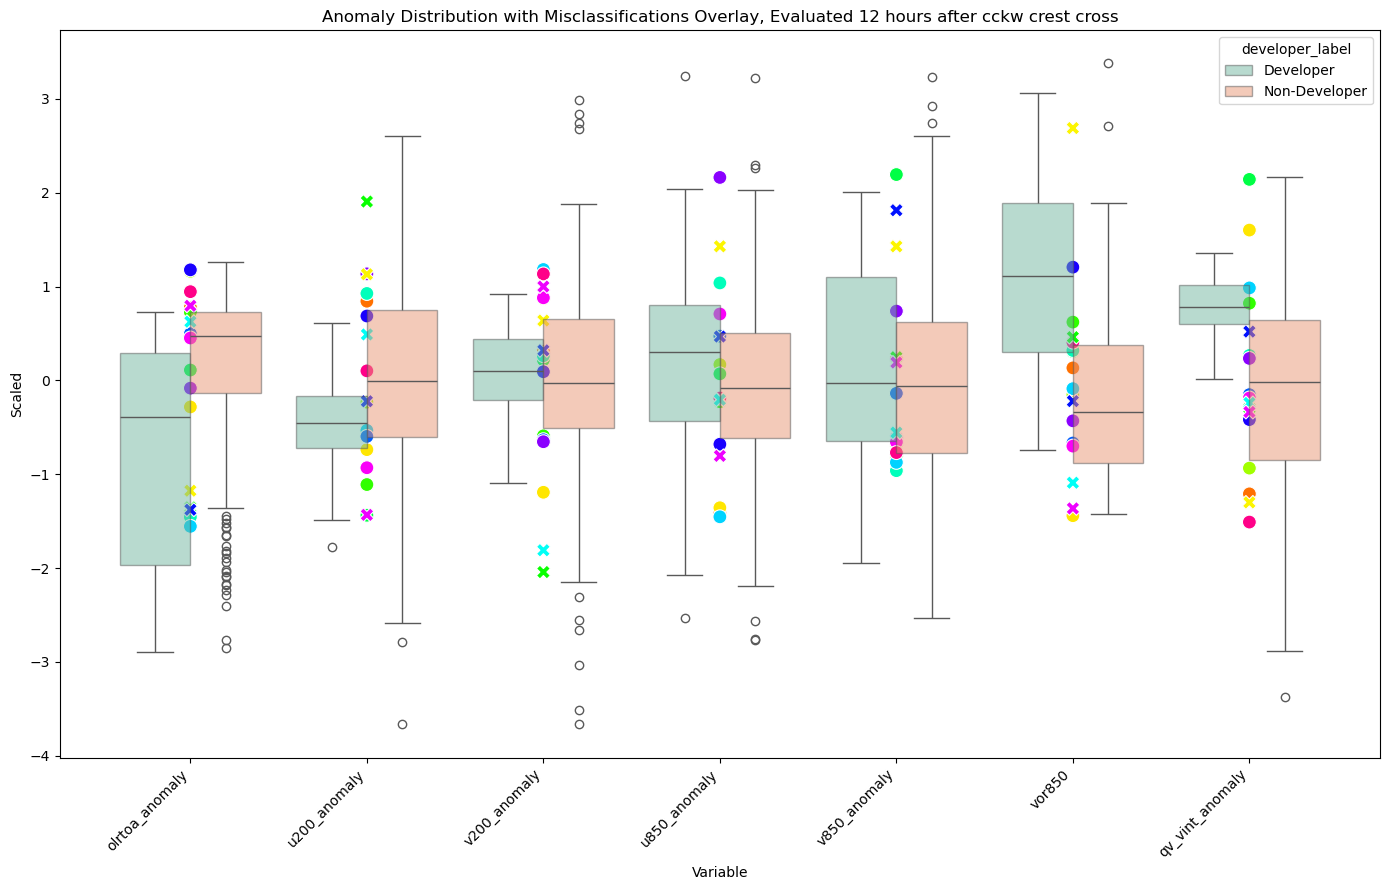

In [71]:
plt.figure(figsize=(14,9))

# 1) your original boxplot
sns.boxplot(
    data=melted,
    x='Variable',
    y='Scaled',
    hue='developer_label',
    palette='Set2',
    boxprops={'alpha': 0.5}   # <-- make boxes 30% opaque

)

# scatter of all FPs, each with its own hue
fp_only = mis_melted[mis_melted['error_type']=='False Positive']
sns.scatterplot(
    data=fp_only,
    x='Variable', y='Scaled',
    hue='sample_id',         # <–– each sample_id gets its own color
    palette='hsv',           # or 'tab20', 'gist_rainbow', etc.
    marker='o',
    s=100,
    legend=False,            # hide the huge legend, or set True if you want it
    label='False Positive'

)

# scatter of FNs each with its own hue
fn_only = mis_melted[mis_melted['error_type']=='False Negative']
sns.scatterplot(
    data=fn_only,
    x='Variable', y='Scaled',
    hue='sample_id',           # or whatever you like
    marker='X',
    palette='hsv',           # or 'tab20', 'gist_rainbow', etc.
    s=100,
    legend=False,
    label='False Positive'

)


plt.title(f'Anomaly Distribution with Misclassifications Overlay, Evaluated {dt_cckw_cross_hrs} hours after cckw crest cross')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



